In [1]:
import pandas as pd
from arch.unitroot import ADF, KPSS
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Extrayendo variable a analizar desde base de datos de Yunque Capital
imae = "'MRD-SR-05-01'" #indice en base de datos de Yunque Capital
conn = pyodbc.connect(driver='{ODBC Driver 17 for SQL Server}', 
                    server='<servername>', 
                    database='<databasename>', 
                    uid='<user>', 
                    pwd='<password>')
c= conn.cursor()
query = "EXEC selectVariable @INDICE =" + str(imae) #Query a la base de datos
df = pd.read_sql(query,conn) #Enviando query a base de datos
df["Fecha"]=pd.to_datetime(df['Fecha'], utc=True) #Cambiando formato de columna de fechas
df = df.set_index('Fecha') #Estableciendo indice de fechas
df

OperationalError: ('08001', '[08001] [Microsoft][ODBC Driver 17 for SQL Server]Named Pipes Provider: Could not open a connection to SQL Server [53].  (53) (SQLDriverConnect); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Login timeout expired (0); [08001] [Microsoft][ODBC Driver 17 for SQL Server]A network-related or instance-specific error has occurred while establishing a connection to SQL Server. Server is not found or not accessible. Check if instance name is correct and if SQL Server is configured to allow remote connections. For more information see SQL Server Books Online. (53)')

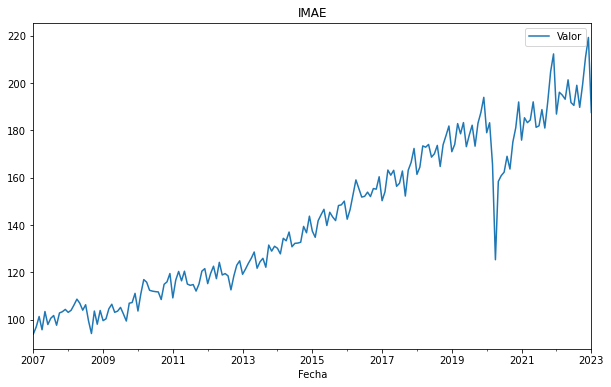

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(title="IMAE", ax=ax)

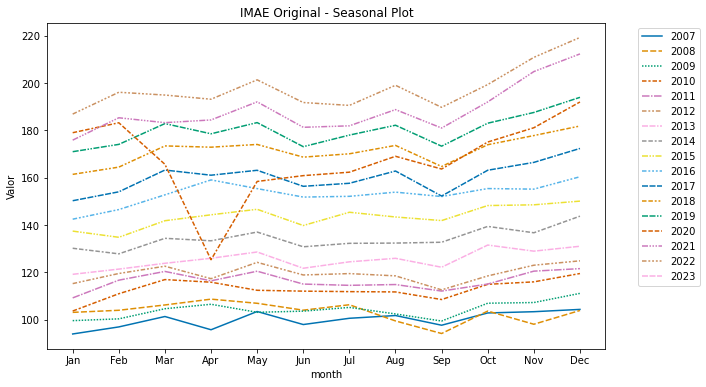

In [23]:
import seaborn as sns

#Separando mes y año para analizar estacionalidad
dfsns = df.copy()
dfsns["year"]=dfsns.index.year
dfsns["month"]=dfsns.index.strftime("%b")
#Creando grafico de parametros necesarios
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=dfsns,
            x="month",
            y="Valor",
            hue="year",
            style="year",
            legend="full",
            palette="colorblind")
plt.title("IMAE Original - Seasonal Plot")
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

In [27]:
#Test de estacionaridad de Dickey-Fuller
adf = ADF(df["Valor"])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                  0.474
P-value                         0.984
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [14]:
def kpss_test(x, h0_type="c"): 
    indices = ["Test Statistic", "p-value", "# of Lags"]
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f"Critical Value ({key})"] = value
    return results

In [16]:
kpss_test(df["Valor"])

C:\Users\Yunue Capital\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic           2.00523
p-value                  0.01000
# of Lags                9.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64

In [53]:
#Test de estacionaridad de Phillips-Perron
adf = KPSS(df["primera_diferencia"].dropna())
print(adf.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  0.053
P-value                         0.861
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [45]:
#Calcualndo diferencias
df["primera_diferencia"] = df.Valor.diff(1)

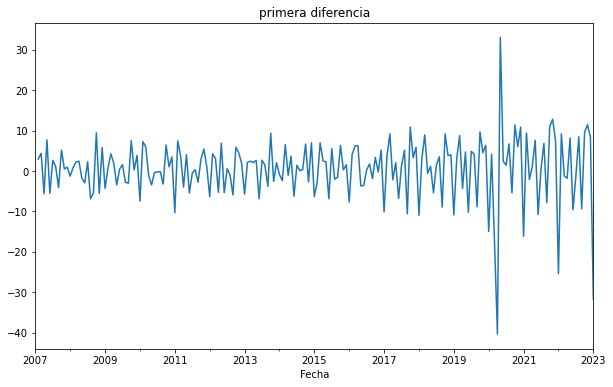

In [51]:
#mpliar tamaño de grafico
fig, ax = plt.subplots(figsize=(10, 6))
#graficar primera diferencia
df["primera_diferencia"].plot(title="primera diferencia", ax=ax)

In [33]:
#Test de estacionaridad de Dickey-Fuller
adf = ADF(df["primera_diferencia"].dropna())
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.885
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [36]:
import numpy as np
df["valor_log"] = np.log(df.Valor)

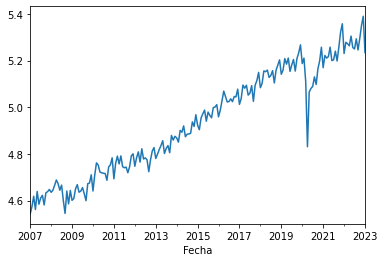

In [37]:
df["valor_log"].plot()

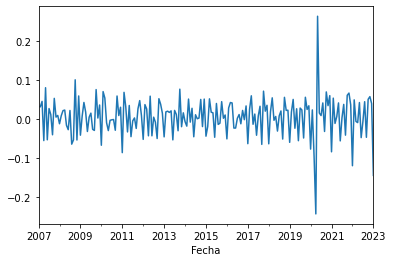

In [40]:
df["Valor"].pct_change().plot()

In [46]:
df["primera_diferencia"]

Fecha
2007-01-01 00:00:00+00:00          NaN
2007-02-01 00:00:00+00:00     2.982811
2007-03-01 00:00:00+00:00     4.398659
2007-04-01 00:00:00+00:00    -5.595266
2007-05-01 00:00:00+00:00     7.707706
                               ...    
2022-09-01 00:00:00+00:00    -9.317525
2022-10-01 00:00:00+00:00     9.631273
2022-11-01 00:00:00+00:00    11.487960
2022-12-01 00:00:00+00:00     8.413946
2023-01-01 00:00:00+00:00   -31.696303
Name: primera_diferencia, Length: 193, dtype: float64